# PoC 1


In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
import os
import matplotlib.pyplot as plt
import logging
import seaborn as sns

%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize the data

In [2]:
n_samples = 1000

n_contributers = [2, 4] # one influencer in level 1 and 4 on level 1

gen_avg = 0
gen_sig = 7


## setup the individual random generators

In [3]:
def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    return {lvl : {i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)}

def print_coefficients(contributer_coefficients):
    for m, stage in contributer_coefficients.items():
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [4]:
# easy as a start
cc_02 = {0: {    0: (1, 4), 
                1: (-1, 4)},
        1: {    0: (1, 1),
                1: (2, 1),
                2: (3, 1),
                3: (4, 1)}}
cc_01 = {0: {    0: (1, 1),
                1: (2, 1)}}

In [5]:
print_coefficients(cc_01)

Stage 0: Contributer 0 mu=1.00, sig=1.00
Stage 0: Contributer 1 mu=2.00, sig=1.00


## Create the Data

In [6]:
def gen_data(gen_avg, gen_sig, n_samples, contributer_coefficients):
    """generate random data.
    
    Inputs:
    * gen_avg: mean for the baseline
    * gen_sig: sigma for the baseline
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    data = np.random.normal(gen_avg, gen_sig, n_samples)
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
    return torch.from_numpy(data), torch.from_numpy(contributers)

# Reference Model

In [47]:
%reset -sf
from torch.distributions import constraints

In [22]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [23]:
def africa_model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [24]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [26]:
from pyro.infer import SVI, Trace_ELBO


svi = SVI(africa_model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 500 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 100 == 0:
        logging.info("Elbo loss: {}".format(elbo))

NameError: name 'constraints' is not defined

# My Try

In [7]:
# generate the data
data, contributers = gen_data(gen_avg=0,
                              gen_sig=10,
                              n_samples=1000,
                              contributer_coefficients=cc_01)

creating level 0


In [20]:
pyro.clear_param_store()
"""
def model(contributers, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_0 = pyro.sample("b1", dist.Normal(0., 1.))
    b_1 = pyro.sample("b2", dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=data)
"""

def model0(contibuters, data):
    """simplest model with only one normal distribution"""
    m = pyro.sample("m", dist.Normal(0, 1))
    sd = pyro.sample("sd", dist.LogNormal(m, 1))
    with pyro.plate("N", len(data)):
        pyro.sample("obs", dist.Normal(m, sd), obs=data)

def model(contributers, data):
    
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    #mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", (dist.Normal(a_m, a_s)
                                    +  (contributers == 0) * dist.Normal(b_0_m, b_0_s)
                                    + (contributers == 1) * dist.Normal(b_1_m, b_1_s))
                           , obs=data)
    
def model2(contributers, data):
    
    a = pyro.param("a", dist.Normal(0., 10.))


    b_0 = pyro.param("b_0", dist.Normal(0., 1.))

    b_1 = pyro.param("b_1", dist.Normal(0., 1.))
    sigma = pyro.param("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)
    
def model3(c0, c1, data):
    
    a = pyro.param("a", dist.Normal(0., 10.))


    b_0 = pyro.param("b_0", dist.Normal(0., 1.))

    b_1 = pyro.param("b_1", dist.Normal(0., 1.))
    sigma = pyro.param("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model3b(c0, c1, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))


    b_0 = pyro.sample("b_0", dist.Normal(0., 1.))

    b_1 = pyro.sample("b_1", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model3c(c0, c1, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model4(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model5(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    return mean
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", mean, obs=data)

def model6(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    
    with pyro.plate("data", len(data)):
        return mean
    
def model7(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 3.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(-b_0_m, b_1_s))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1

    #z = b_0_m + b_1_m
    #with pyro.condition(data={"z":torch.zeros(1)}):
    #    z = pyro.sample("z", dist.Normal(0, 1))
    
    with pyro.plate("data", len(data)):
        return mean
        #return pyro.sample("obs", mean, obs=data)

In [10]:
c0 = torch.tensor((contributers==0).clone(), dtype=torch.float)
c1 = torch.tensor((contributers==1).clone(), dtype=torch.float)


C:\Users\fuerf\AppData\Local\Temp\ipykernel_4508\2458544639.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c0 = torch.tensor((contributers==0).clone(), dtype=torch.float)
C:\Users\fuerf\AppData\Local\Temp\ipykernel_4508\2458544639.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c1 = torch.tensor((contributers==1).clone(), dtype=torch.float)


In [9]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO


def get_svi(model):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model,
            guide,
            optim.Adam({"lr": .01}),
            loss=Trace_ELBO())
    return guide, svi





In [ ]:
num_iters = 5000 if not smoke_test else 2
guide, svi = get_svi(model4)

for i in range(num_iters):
    elbo = svi.step(contributers.squeeze(-1), data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

In [21]:
num_iters = 10000 if not smoke_test else 2
guide, svi = get_svi(model7)

for i in range(num_iters):
    elbo = svi.step(contributers.squeeze(-1), data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 13.311810970306396
Elbo loss: 4.826231002807617
Elbo loss: 1.9751653671264648
Elbo loss: 1.5112595558166504
Elbo loss: 0.7701191902160645
Elbo loss: 0.698760986328125
Elbo loss: 0.544931173324585
Elbo loss: -0.43741321563720703
Elbo loss: 0.033102989196777344
Elbo loss: 0.27290964126586914
Elbo loss: -0.0529327392578125
Elbo loss: -0.0786595344543457
Elbo loss: 0.5872225761413574
Elbo loss: -0.03875017166137695
Elbo loss: -0.04347372055053711
Elbo loss: -0.07947587966918945
Elbo loss: 0.030519723892211914
Elbo loss: 0.0908350944519043
Elbo loss: -0.03679394721984863
Elbo loss: -0.005917072296142578


In [11]:
def plotter(guide, contributers, data, variables):
    with pyro.plate("samples", 800, dim=-1):
        samples = guide(contributers, data)

    assert type(variables) == list

    fig = plt.figure(figsize=(10, 6))
    for var in variables:
        sns.histplot(samples[var].detach().cpu().numpy(), kde=True, stat="density", label=var)

    plt.legend()
    plt.show()

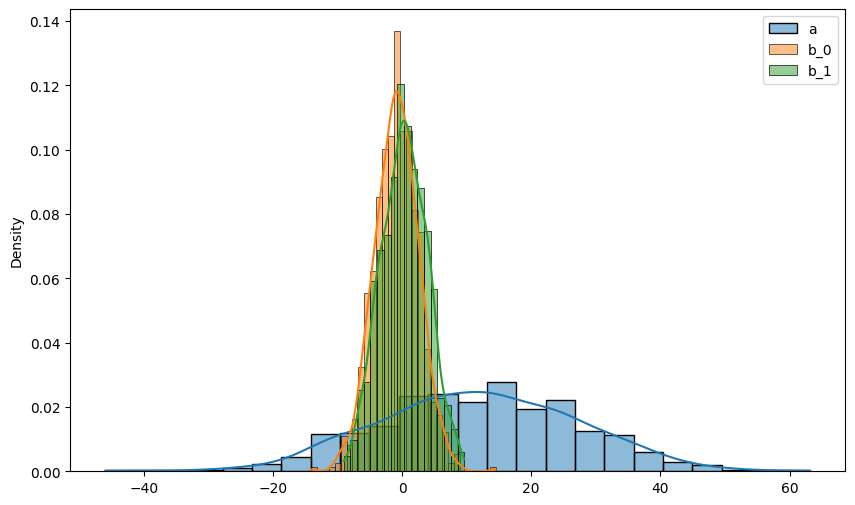

In [22]:
plotter(guide, contributers, data, ["a", "b_0", "b_1"])

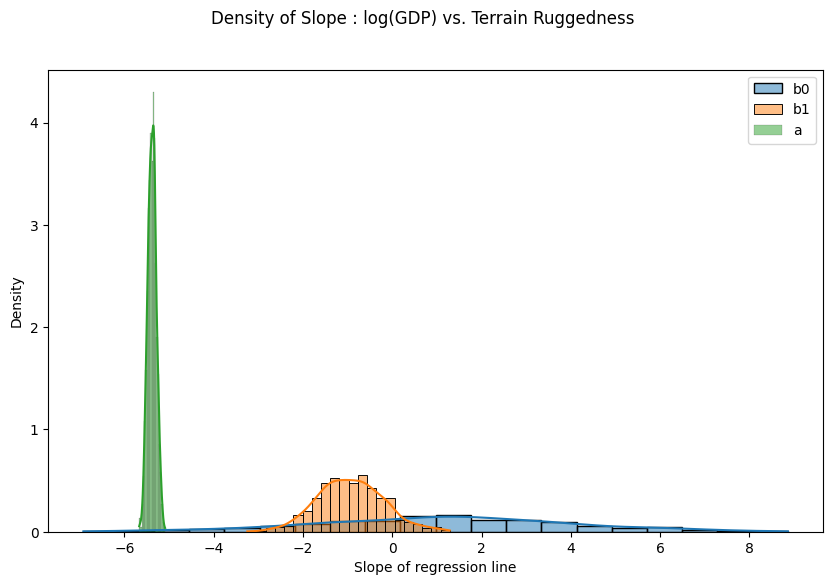

In [17]:
with pyro.plate("samples", 800, dim=-1):
    samples = guide(contributers, data)

sample_0 = samples["b_0"]
sample_1 = samples["b_1"]
sample_a = samples["a"]
#sample_s = samples["sigma"]

fig = plt.figure(figsize=(10, 6))
sns.histplot(sample_0.detach().cpu().numpy(), kde=True, stat="density", label="b0")
sns.histplot(sample_1.detach().cpu().numpy(), kde=True, stat="density", label="b1")
sns.histplot(sample_a.detach().cpu().numpy(), kde=True, stat="density", label="a")
#sns.histplot(sample_s.detach().cpu().numpy(), kde=True, stat="density", label="sigma")

fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

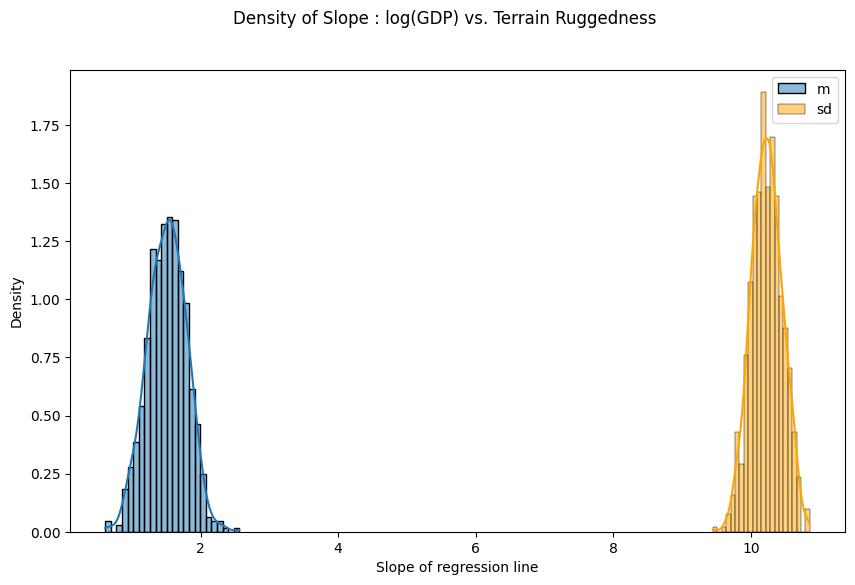

In [55]:
num_iters = 5000 if not smoke_test else 2
guide, svi = get_svi(model3)
# runs with models 3b and 3c

for i in range(num_iters):
    elbo = svi.step(c0.squeeze(-1), c1.squeeze(-1), data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

with pyro.plate("samples", 800, dim=-1):
    samples = guide(contributers, data)

sample_m = samples["m"]
sample_sd = samples["sd"]

fig = plt.figure(figsize=(10, 6))
sns.histplot(sample_m.detach().cpu().numpy(), kde=True, stat="density", label="m")
sns.histplot(sample_sd.detach().cpu().numpy(), kde=True, stat="density", label="sd", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [49]:
svi

In [35]:
(torch.tensor([1, 2, 3]) == 1) * torch.ones(3)

tensor([1., 0., 0.])

In [2]:
import numpy as np
import pandas as pd
import pyro
import pyro.optim as optim
import torch
import os
import matplotlib.pyplot as plt
import logging

%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

def gen_data(gen_avg, gen_sig, n_samples, contributer_coefficients):
    """generate random data.
    
    Inputs:
    * gen_avg: mean for the baseline
    * gen_sig: sigma for the baseline
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    data = np.random.normal(gen_avg, gen_sig, n_samples)
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
    return torch.from_numpy(data), torch.from_numpy(contributers)

# parameters for the two contributors in level 0
cc_01 = {0: {    0: (1, 1),
                1: (2, 1)}}

# generate the data
data, contributers = gen_data(gen_avg=0,
                              gen_sig=10,
                              n_samples=1000,
                              contributer_coefficients=cc_01)

pyro.clear_param_store()
def model(contributers, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_0 = pyro.sample("b1", dist.Normal(0., 1.))
    b_1 = pyro.sample("b2", dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = (a + (contributers == 0) * b_0 + (contributers == 1) * b_1).to_event()
    
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

from pyro.infer import SVI, Trace_ELBO

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

num_iters = 100 if not smoke_test else 2

for i in range(num_iters):
    elbo = svi.step(contributers, data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


creating level 0


AttributeError: 'Tensor' object has no attribute 'to_event'